### Metropolis–Hastings MCMC sampling with fixing baryon density Ωb_h^2

In [1]:
using CSV,DataFrames,ProgressBars,Statistics,ProgressBars,Distributions,Plots,PairPlots

In [2]:
function log_likelihood_no_Ωm(z_grid,del_z,DM_list,Ωb_h2,initial_guess)
    h, Ωm, DM_host_avg = initial_guess
    if (0.2 < Ωm < 0.4 && 0.2 < h < 1 && -400 < DM_host_avg < 200)
        #println("Ωm = ",Ωm," h=",h)
        return sum([log_likelihood_ith_no_Ωm(DM_list[i],z_grid[i],del_z,h,Ωm,DM_host_avg,Ωb_h2) for i in 1:length(DM_list)])
    else
        return -prevfloat(typemax(Float64))
    end                
end

function log_likelihood_ith_no_Ωm(DM_i,z_i,del_z,h,Ωm,DM_host_avg,Ωb_h2)
    return log(likelihood_ith_no_Ωm(DM_i, z_i,del_z, h, Ωm,DM_host_avg, Ωb_h2))
end

function likelihood_ith_no_Ωm(DM_i, z_i,del_z,h,Ωm,DM_host_avg,Ωb_h2)
    sigsq = sigmasq_without_MW_no_Ωm(z_i)
    return (2*pi*sigsq)^(-1/2)*exp(-(DM_i - DM_theo_no_Ωm(z_i,del_z,h,Ωm,DM_host_avg,Ωb_h2))^2/(2*sigsq))
end

function DM_theo_no_Ωm(z,del_z,h,Ωm,DM_host_avg,Ωb_h2)
    return DM_LSS_no_Ωm(z,del_z,h,Ωm,Ωb_h2) + DM_host_no_Ωm(z, DM_host_avg) # pc cm^-3     
end
function DM_host_no_Ωm(z,DM_host_avg)
    return DM_host_avg/(1+z) # pc cm^-3
end
function sigmasq_without_MW_no_Ωm(z)
    return (50 / (1 + z))^2 + (40 + 140 * z)^2 # (pc cm^-3)^2
end
function DM_LSS_no_Ωm(z,Δz,h,Ωm,Ωb_h2)
# Given constants
    G = 6.67408e-11
    c = 299792458
    m_p = 1.6726219e-27
    pc = 3.0856775814914E+18
    Mpc = 3.0856775814914E+22 #m
    
    #parameters
    χ_e = 0.88
    fIGM = 0.84
    #H0 = 100*h (km/s/Mpc) used to replace H0 in given eqn

    z_sample = collect(0:Δz:z)
    Ez_sample = zeros(length(z_sample))

    for i in 1:length(z_sample)
        Ez_sample[i] = sqrt(Ωm*h^2(1 + z_sample[i])^3 + h^2*(1-Ωm))
    end
    prefactor = χ_e*fIGM*300*c*Ωb_h2/(8*pi*m_p*G)
    DMLSS =  prefactor*sum(((1 + z_sample[i])/Ez_sample[i])*Δz for i in 1:length(z_sample)) # pc/m
    return (1E-5)*DMLSS/(pc^2) # factor 1E-5/pc^2 used to get prefactor in pc/cm^3
end

DM_LSS_no_Ωm (generic function with 1 method)

In [3]:
# using mock data
chimefrbs_mock_data = CSV.read("chimefrbcat_mock.csv",DataFrame)
DM_list = chimefrbs_mock_data.DM_obs - chimefrbs_mock_data.DM_MW_YMW16
z_grid = chimefrbs_mock_data.redshift


# initial parameters
del_z = 0.1
Ωb_h2 = 0.02237
h = 0.67
Ωm = 0.3
DM_host_avg = 90

initial_guess = [h, Ωm, DM_host_avg] # initial guess
parsigma=[1E-4,1E-4,10]   # proposal distribution

total_walkers = 50
nsample = 1E4
nburn =  1000
bestfit1 = [Vector{Float64}[] for i in 1:total_walkers]
initial_guesses = [initial_guess .+ parsigma .* randn(3) for i in 1:total_walkers]
#initial_guesses = hcat(rand.(Normal.(initial_guess[:],parsigma[:]),total_walkers,)...)
accepted_samples = [Vector{Float64}[] for i in 1:total_walkers]

Threads.@threads for i in ProgressBar(1:total_walkers)
    init_pars = initial_guesses[i]
    #println(typeof(init_pars))
    init_lik = log_likelihood_no_Ωm(z_grid,del_z,DM_list,Ωb_h2,init_pars)
    current_lik = init_lik
    best_lik = init_lik
    bestfit = init_pars
    current_pars =init_pars 

    for j in 1:nsample

        new_pars = current_pars .+ parsigma .* randn(3)
        #new_pars = vec(hcat(rand.(Normal.(current_pars[:],parsigma[:]),1,)...))
        
        #Calculate log_likelihood for the new_pars
        new_lik = log_likelihood_no_Ωm(z_grid,del_z,DM_list,Ωb_h2,new_pars)
        u = rand()        
        test = exp(new_lik-current_lik)        
        if u < test
            #Accept
            current_lik = new_lik
            current_pars = new_pars

        end
        if current_lik > best_lik
            bestfit = current_pars
            best_lik = current_lik
        end
        if j > nburn
            push!(accepted_samples[i],Vector(current_pars))            
            push!(bestfit1[i],Vector(bestfit))


        end
    end
    #println(bestfit)
end
# formation of accepted samples into matrix form
samples = reduce(hcat,(vcat(accepted_samples...)))
bestfit1 = reduce(hcat,(vcat(bestfit1...)))



0.0%┣                                               ┫ 0/50 [00:00<00:-3, -0s/it]
2.0%┣▉                                          ┫ 1/50 [00:00<Inf:Inf, InfGs/it]
4.0%┣██                                              ┫ 2/50 [00:05<04:14, 5s/it]
6.0%┣██▉                                             ┫ 3/50 [00:10<03:55, 5s/it]
8.0%┣███▉                                            ┫ 4/50 [00:15<03:45, 5s/it]
10.0%┣████▊                                          ┫ 5/50 [00:19<03:38, 5s/it]
12.0%┣█████▋                                         ┫ 6/50 [00:24<03:32, 5s/it]
14.0%┣██████▋                                        ┫ 7/50 [00:29<03:26, 5s/it]
16.0%┣███████▌                                       ┫ 8/50 [00:34<03:24, 5s/it]
18.0%┣████████▌                                      ┫ 9/50 [00:39<03:18, 5s/it]
20.0%┣█████████▏                                    ┫ 10/50 [00:44<03:14, 5s/it]
22.0%┣██████████▏                                   ┫ 11/50 [00:48<03:08, 5s/it]
24.0%┣███████████           

3×450000 Matrix{Float64}:
    0.68293      0.68293      0.68316   …     0.805186     0.805186
    0.296006     0.296006     0.295907        0.268148     0.268148
 -334.083     -334.083     -325.608        -253.302     -253.302

┌ Warning: Non-ascii labels detected. Some plotting backends require passing these using LaTeX escapes, e.g. \alpha instead of α
└ @ PairPlots ~/.julia/packages/PairPlots/JBwEZ/src/corner.jl:49


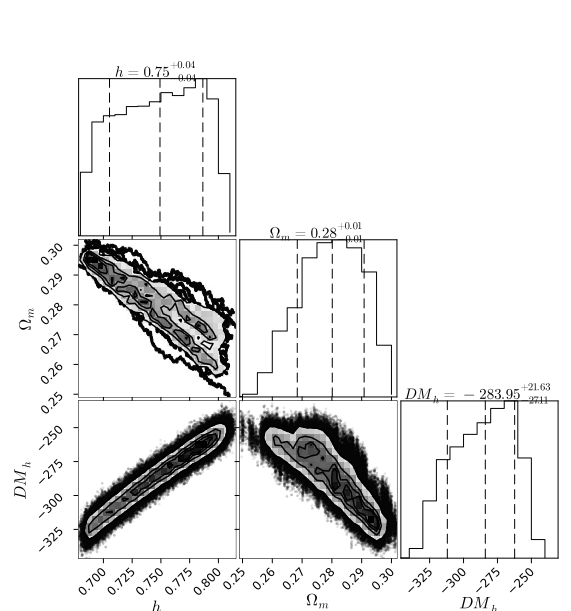

In [4]:
h = samples[1,:]
Ω_m = samples[2,:]
DM_h = samples[3,:]
table = (;h,Ω_m,DM_h)
corner(table)
savefig("pairplots.png")

using Images, FileIO,ImageShow
img = load("pairplots.png")



### Metropolis–Hastings MCMC sampling for H0, Ωm, Ωb, and DM_host_avg

In [26]:
function log_likelihood(z_grid,del_z,DM_list,initial_guess1) 
    H0, Ωm, Ωb, DM_host_avg = initial_guess1
    
    if (0.2 < Ωm < 0.4 && 55 < H0 < 75 && 80 < DM_host_avg < 130 && 0.001 < Ωb < 0.04)
        return sum([log_likelihood_ith(DM_list[i],z_grid[i],del_z,H0,DM_host_avg,Ωb,Ωm) for i in 1:length(DM_list)])
    else
        return -prevfloat(typemax(Float64))
    end   
end

function log_likelihood_ith(DM_i,z_i,del_z,H0,DM_host_avg,Ωb,Ωm)
    return log(likelihood_ith(DM_i, z_i,del_z, H0, DM_host_avg, Ωb, Ωm))
end

function likelihood_ith(DM_i, z_i,del_z, H0, DM_host_avg, Ωb, Ωm)
    sigmasq = sigma_withuot_MW(z_i)
    return (2*pi*sigmasq)^(-1/2)*exp(-(DM_i - DM_theo(z_i,del_z, H0, Ωb, Ωm, DM_host_avg))^2/(2*sigmasq))
end

function DM_theo(z,del_z, H0, Ωb, Ωm,DM_host_avg)
    return DM_LSS(z,del_z, H0, Ωb, Ωm) + DM_host(z, DM_host_avg) # pc cm^-3     
end
function DM_host(z,DM_host_avg)
    return DM_host_avg/(1+z) # pc cm^-3
end
function sigma_withuot_MW(z)
    return (50 / (1 + z))^2 + (40 + 140 * z)^2 # (pc cm^-3)^2
end
function DM_LSS(z,Δz,H0,Ωb,Ωm)
# Given constants
    G = 6.67408e-11
    c = 299792458
    m_p = 1.6726219e-27
    pc = 3.0856775814914E+18
    Mpc = 3.0856775814914E+22
    
    #parameters
    χ_e = 0.88
    fIGM = 0.84
    #H0 = 100*h (km/s/Mpc) used to replace H0 in given eqn

    z_sample = collect(0:Δz:z)
    Ez_sample = zeros(length(z_sample))

    for i in 1:length(z_sample)
        Ez_sample[i] = sqrt(Ωm*(1 + z_sample[i])^3 + (1-Ωm))
    end
    prefactor = χ_e*fIGM*3*c*Ωb/(8*pi*m_p*G)
    DMLSS =  prefactor*sum(((1 + z_sample[i])/Ez_sample[i])*Δz for i in 1:length(z_sample)) # pc/m
    return (1E-5)*DMLSS/(pc^2) # factor 1E-5/pc^2 used to get prefactor in pc/cm^3

end

DM_LSS (generic function with 1 method)

In [40]:
# using mock data
chimefrbs_mock_data = CSV.read("chimefrbcat_mock.csv",DataFrame)
DM_list = chimefrbs_mock_data.DM_obs - chimefrbs_mock_data.DM_MW_YMW16
z_grid = chimefrbs_mock_data.redshift


# initial parameters
del_z  = 0.1
H0 = 70
Ωm = 0.3
Ωb = 0.04
DM_host_avg = 90

parsigma1=[0.01,1E-4,1E-5,0.01]   # proposal distribution
initial_guess1 = [H0,Ωm,Ωb,DM_host_avg] # initial guess
     

total_walkers = 100
nsample = 1E4
nburn = 1000

initial_guesses1 = [initial_guess1 .+ parsigma1 .* randn(4) for i in 1:total_walkers]
accepted_samples1 = [Vector{Float64}[] for i in 1:total_walkers]

Threads.@threads for i in ProgressBar(1:total_walkers)
    init_pars = initial_guesses1[i]
    init_lik = log_likelihood(z_grid,del_z,DM_list,init_pars)   
    current_lik = init_lik
    best_lik = init_lik
    bestfit = init_pars
    current_pars =init_pars 

    for j in 1:nsample

        new_pars = current_pars .+ parsigma1 .* randn(4)
        
        #Calculate log_likelihood for the new_pars
        new_lik = log_likelihood(z_grid,del_z,DM_list,new_pars)          
        u = rand()
        test = exp(new_lik-current_lik)
        if u < test
            #Accept
            current_lik = new_lik
            current_pars = new_pars
        end
        if current_lik > best_lik
            bestfit = current_pars
            best_lik = current_lik
        end
        if j > nburn
            push!(accepted_samples1[i],Vector(current_pars))

        end
    end
    #println(bestfit)
end
# formation of accepted samples into matrix form
samples1 = reduce(hcat,(vcat(accepted_samples1...)))



0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:00<Inf:Inf, InfGs/it]
2.0%┣█                                              ┫ 2/100 [00:04<06:16, 4s/it]
3.0%┣█▍                                             ┫ 3/100 [00:08<06:04, 4s/it]
4.0%┣█▉                                             ┫ 4/100 [00:11<05:58, 4s/it]
5.0%┣██▍                                            ┫ 5/100 [00:15<05:56, 4s/it]
6.0%┣██▉                                            ┫ 6/100 [00:19<05:51, 4s/it]
7.0%┣███▎                                           ┫ 7/100 [00:22<05:45, 4s/it]
8.0%┣███▊                                           ┫ 8/100 [00:26<05:41, 4s/it]
9.0%┣████▎                                          ┫ 9/100 [00:30<05:37, 4s/it]
10.0%┣████▌                                        ┫ 10/100 [00:33<05:32, 4s/it]
11.0%┣█████                                        ┫ 11/100 [00:37<05:28, 4s/it]
12.0%┣█████▍                

4×900000 Matrix{Float64}:
 69.5598     69.5549     69.5558     …  69.9289     69.9201     69.911
  0.297559    0.297529    0.297672       0.286894    0.286952    0.286844
  0.0397849   0.0397782   0.0397636      0.0408256   0.0408346   0.0408255
 90.284      90.2923     90.3003        91.7701     91.7609     91.7705

┌ Warning: Non-ascii labels detected. Some plotting backends require passing these using LaTeX escapes, e.g. \alpha instead of α
└ @ PairPlots ~/.julia/packages/PairPlots/JBwEZ/src/corner.jl:49


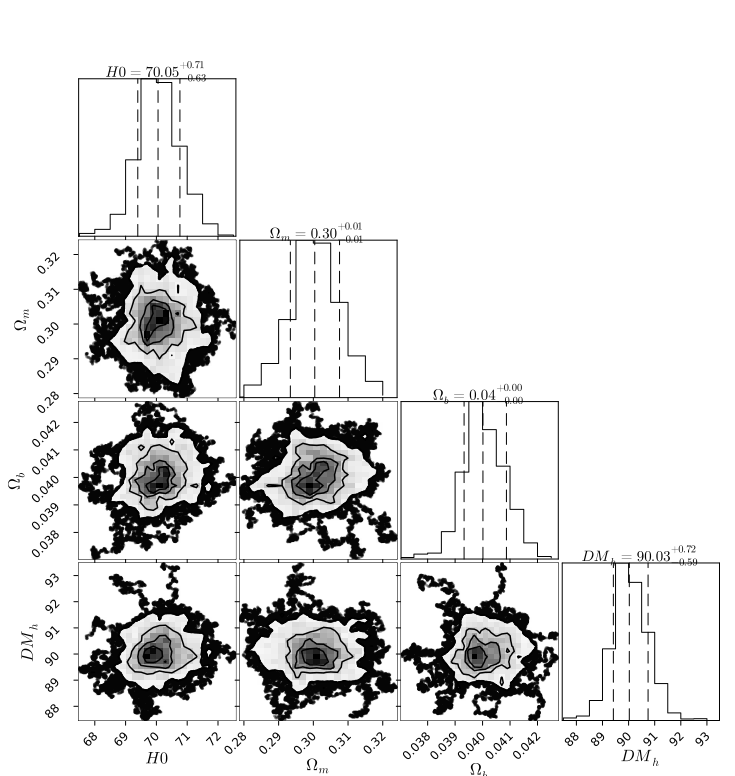

In [41]:
H0 = samples1[1,:]
Ω_m = samples1[2,:]
Ω_b = samples1[3,:]
DM_h = samples1[4,:]
table1 = (;H0,Ω_m,Ω_b,DM_h)
corner(table1)
savefig("pairplots1.png")

using Images, FileIO,ImageShow
img = load("pairplots1.png")
